# The code and data are from https://github.com/nds-group/ran-updates

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import os

In [92]:
# select the granularity of data and event type
granularity = 'hour' # hour or day
event_type = "5G addition" # both or 4G addition or 5G addition

In [93]:
# load data
df_traffic = pd.read_parquet('traffic_dataset.parquet')
df_info_full = pd.read_parquet('info_dataset.parquet')

## Data investigation

In [94]:
df_info_full['event_type'].unique(), df_info_full['urbanization'].unique(), len(df_info_full['UUID'].unique()), len(df_traffic['UUID'].unique())

(array(['5G addition', '4G addition'], dtype=object),
 array(['Suburban', 'Urban', 'Metropolitan', 'Rural',
        'Metropolitan Center'], dtype=object),
 1931,
 1931)

In [95]:
if event_type == 'both':
    df_info = df_info_full.copy()
elif event_type == "4G addition" or event_type == "5G addition":
    df_info = df_info_full[df_info_full["event_type"] == event_type].copy()
else: 
    raise Exception('Incorrect event type')

In [96]:
# Get a single carrier's time series
random_antenna = 12
sample_uuid = df_info['UUID'].iloc[random_antenna]
sample_antennaID = df_info['antennaID'].iloc[random_antenna]
sample_urbanization = df_info['urbanization'].iloc[random_antenna]
sample_technology = df_info['technology'].iloc[random_antenna]
sample_event_type = df_info['event_type'].iloc[random_antenna]

carrier_traffic = df_traffic[df_traffic['UUID'] == sample_uuid].copy()
carrier_traffic = carrier_traffic.sort_values('deltaT').reset_index(drop=True)

# Convert deltaT to days and aggregate to daily level
carrier_traffic['days'] = carrier_traffic['deltaT'] / 3600 / 24
daily_traffic = carrier_traffic.groupby(carrier_traffic['days'].astype(int))['DL'].mean()

carrier_traffic['hours'] = carrier_traffic['deltaT'] / 3600
hourly_traffic = carrier_traffic.groupby(carrier_traffic['hours'].astype(int))['DL'].mean()

In [97]:
carrier_traffic

,UUID,DL,UL,deltaT,days,hours
0,65b398774f9b2ede,-0.314135,-0.069401,-5342400.0,-61.833333,-1484.0
1,65b398774f9b2ede,4.240907,0.707891,-5338800.0,-61.791667,-1483.0
2,65b398774f9b2ede,6.453011,1.457095,-5335200.0,-61.750000,-1482.0
3,65b398774f9b2ede,0.408465,0.022072,-5331600.0,-61.708333,-1481.0
4,65b398774f9b2ede,1.918861,1.012778,-5328000.0,-61.666667,-1480.0
...,...,...,...,...,...,...
3014,65b398774f9b2ede,-0.415187,-0.182427,5508000.0,63.750000,1530.0
3015,65b398774f9b2ede,-0.500749,-0.257721,5511600.0,63.791667,1531.0
3016,65b398774f9b2ede,1.109979,-0.088732,5515200.0,63.833333,1532.0
3017,65b398774f9b2ede,-0.542490,-0.280264,5518800.0,63.875000,1533.0


In [98]:
if granularity == 'hour':
    traffic = hourly_traffic
    event_length = 7*24  # 168 hours (1 week)
    decomposition = seasonal_decompose(traffic, model='additive', period=24) # 24 hours as period
elif granularity == 'day':
    traffic = daily_traffic
    event_length = 7  # 1 week
    decomposition = seasonal_decompose(traffic, model='additive', period=7) # weekly
else: 
    raise Exception('Incorrect granularity --> update the code to use the granularity you want starting from hours')

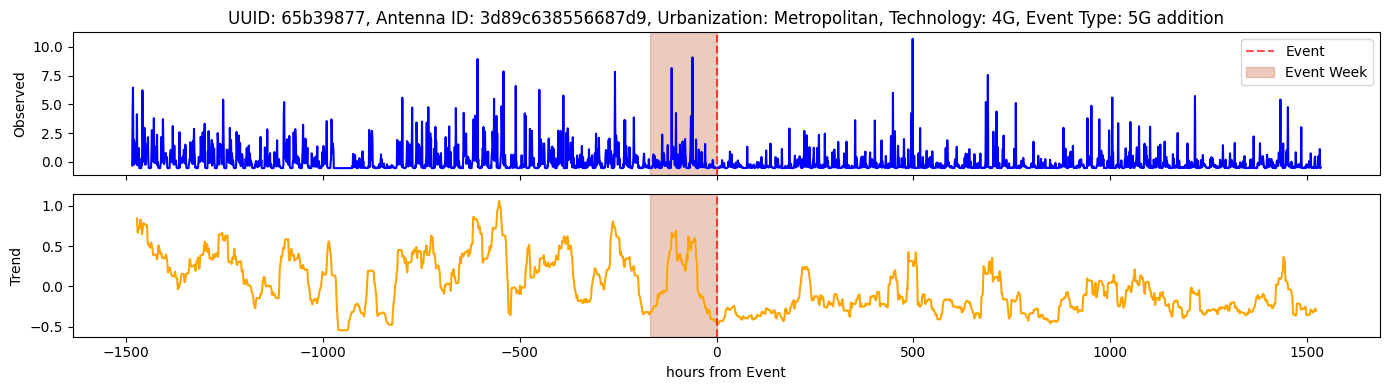

In [99]:
# Plot the decomposition
fig, axes = plt.subplots(2, 1, figsize=(14, 4), sharex=True)

axes[0].plot(traffic.index, decomposition.observed, color='blue')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Event')
axes[0].axvspan(-event_length,  0, alpha=0.4, color='#d17c5a', label='Event Week')
axes[0].set_ylabel('Observed')
axes[0].set_title(f'UUID: {sample_uuid[:8]}, Antenna ID: {sample_antennaID}, Urbanization: {sample_urbanization}, Technology: {sample_technology}, Event Type: {sample_event_type}')
axes[0].legend()

axes[1].plot(traffic.index, decomposition.trend, color='orange')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[1].axvspan(-event_length,  0, alpha=0.4, color='#d17c5a', label='Event Week')

axes[1].set_ylabel('Trend')
axes[1].set_xlabel(f'{granularity}s from Event')

plt.tight_layout()
# plt.savefig('time_series_decomposition.png', dpi=300)
plt.show()

In [100]:
len(decomposition.trend), len(decomposition.observed)

(3019, 3019)

In [74]:
type(decomposition.observed)

pandas.core.series.Series

## Loop over antennas to create dataset

In [ ]:
filename = f'ran_updates_event_{event_type}_{granularity}_granularity.csv'
if os.path.exists(filename):
    os.remove(filename)

for antenna in range(0, len(df_info['UUID'].unique())):
    sample_uuid = df_info['UUID'].iloc[antenna]

    carrier_traffic = df_traffic[df_traffic['UUID'] == sample_uuid].copy()
    carrier_traffic = carrier_traffic.sort_values('deltaT').reset_index(drop=True)

    if granularity == 'hour':
        carrier_traffic['hours'] = carrier_traffic['deltaT'] / 3600
        traffic = carrier_traffic.groupby(carrier_traffic['hours'].astype(int))['DL'].mean()
        event_length = 7*24  # 168 hours (1 week)
        decomposition = seasonal_decompose(traffic, model='additive', period=24) # 24 hours as period
    elif granularity == 'day':
        # Convert deltaT to days and aggregate to daily level
        carrier_traffic['days'] = carrier_traffic['deltaT'] / 3600 / 24
        traffic = carrier_traffic.groupby(carrier_traffic['days'].astype(int))['DL'].mean()
        event_length = 7  # 1 week
        decomposition = seasonal_decompose(traffic, model='additive', period=7) # weekly

    # save file with the first raw being traffic index (0 is the event day) and the rest are traffic time series from antennas
    df = pd.DataFrame({k:[v] for k, v in zip(traffic.index.values, decomposition.observed.values)})
    write_header = not os.path.exists(filename)
    df.to_csv(filename, mode="a", header=write_header, index=False)